Current Time = 09:24:13

************************************************************
use_gpu = 1, use_hash=1, use_thread = 0

************************************************************
K = 2, T = 5, Elapsed = 1.14(sec.)
K = 2, T = 6, Elapsed = 0.90(sec.)
K = 2, T = 7, Elapsed = 1.15(sec.)
K = 2, T = 8, Elapsed = 1.37(sec.)

************************************************************
K = 3, T = 5, Elapsed = 2.44(sec.)
K = 3, T = 6, Elapsed = 2.09(sec.)
K = 3, T = 7, Elapsed = 2.51(sec.)
K = 3, T = 8, Elapsed = 3.27(sec.)


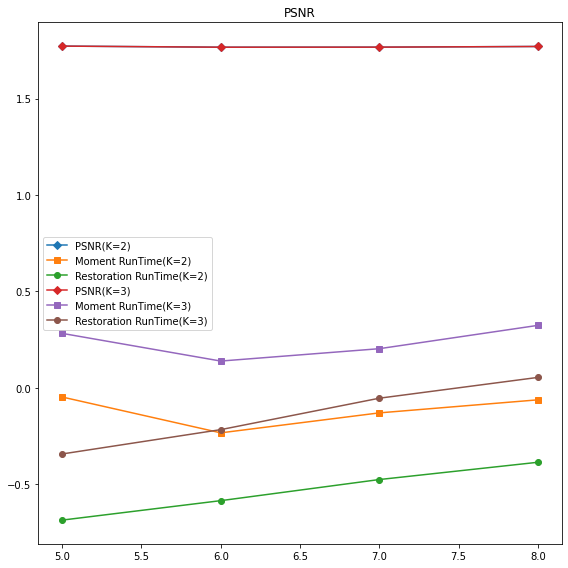


Done.
Wall time: 16.7 s


In [25]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 차수에 따른 연산 속도 

print_curr_time()

def test_moment_restore_times(img_info, Ks, Ts, **options) :
    print( line2 )
    print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }, use_thread = { options['use_thread'] }", flush=True )

    use_gpu = get_option( "use_gpu", **options )
    
    img_input= img_info[ "img" ]
    
    psnrs = numpy.zeros( (len(Ks), len(Ts) ) )
    moment_run_times = psnrs.copy()
    restore_run_times = psnrs.copy()
    
    img_info[ "psnrs" ] = psnrs
    img_info[ "moment_run_times" ] = moment_run_times
    img_info[ "restore_run_times" ] = restore_run_times
    
    for row, K in enumerate( Ks ) : 
        print( line2 )
        
        options[ "hash" ] = {}

        circle_type = "outer"
        
        rho, theta, x, y, dx, dy, k, area = rho_theta( 1000*K, circle_type, **options ) 
        
        img = cv.resize( img_input, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )
        
        np = cupy if use_gpu else numpy
        
        if use_gpu :
            img = cupy.asarray( img )
        pass

        # image scaled
        img_info[ "image scaled" ] = { "title" : f"Origianl Image (K={K})", "img" : img, "K" : K } 

        for col, T in enumerate( Ts ) : 
            then = perf_counter()

            moments, moment_run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
            img_restored, restore_run_time = restore_image(moments, rho, theta, **options )
            
            t_img = img_restored.real
            psnr = calc_psnr( img, t_img, **options ) 
            
            moment_run_times[ row, col ] = moment_run_time
            restore_run_times[ row, col ] = restore_run_time
            psnrs[ row, col ] = psnr

            elapsed = perf_counter() - then

            print( f"K = {K}, T = {T}, Elapsed = {elapsed:.2f}(sec.)" )
        pass
        
        if "hash" in options : 
            del options[ "hash" ]
        pass
    pass
pass # test_moment_restore

def plot_moment_restore_times(img_info, Ks, Ts ) :
    
    psnrs = img_info[ "psnrs" ]
    moment_run_times = img_info[ "moment_run_times" ] 
    restore_run_times = img_info[ "restore_run_times" ]
    
    # 서브 챠트 생성 
    col_cnt = 1 
    row_cnt = 1

    w = 8
    fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(w*col_cnt, w*row_cnt) )
    charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
    chart_idx = 0 
    
    chart = charts[ chart_idx ] ; chart_idx += 1

    for row, K in enumerate( Ks ) : 
        psnr = psnrs[ row ]
        moment_rumtime = moment_run_times[ row ]
        restore_run_time = restore_run_times[ row ]
        
        chart.plot( Ts, numpy.log10( psnr ), marker="D", label= f"PSNR(K={K})" ) 
        chart.plot( Ts, numpy.log10( moment_rumtime ),  marker="s", label= f"Moment RunTime(K={K})" ) 
        chart.plot( Ts, numpy.log10( restore_run_time ),  marker="o", label= f"Restoration RunTime(K={K})" ) 
    pass  

    title = "PSNR"
    
    if len(Ks) < 2 :
        title = f"PSNR (K={Ks[0]})"
        
        chart.set_xlabel( "T" )
    elif len(Ts) < 2 :
        title = f"PSNR (T={Ts[0]})"
        
        chart.set_xlabel( "K" ) 
    pass

    chart.set_ylabel( "log10(y)" )
    chart.set_title( title )

    chart.legend()
    
    plt.tight_layout(); plt.show() 
pass # plot_moment_restore_times

options = {}
options[ "debug" ] = 0 
options[ "use_gpu" ] = 1
options[ "hash" ] = {}
options[ "use_hash" ] = 1  
options[ "use_thread"] = 0 

img_infos = []
    
Ks = numpy.arange( 2, 4, 1 )
Ts = numpy.arange( 5, 8 + 1, 1 )

# 예제 이미지 데이터
img_infos =  [ 
    { "name" : "lena",         "img" : rgb2gray( io.imread( 'image/lenna.png' ) ) } , 
    { "name" : "astronaut",    "img" : rgb2gray( data.astronaut() )} ,
    { "name" : "camera",       "img" : data.camera() },
    
    { "name" : "brick",        "img" : data.brick() },    
    { "name" : "moon",         "img" : data.moon() },
    { "name" : "grass",        "img" : data.grass() },   
] 

img_info = img_infos[0]
        
test_moment_restore_times( img_info, Ks, Ts, **options )
plot_moment_restore_times( img_info, Ks, Ts )

print( "\nDone." )